In [1]:
import torch
from torch.utils import data
from torchvision import transforms
from torchvision.models import resnet152
import os
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('..')
import fdc
from dataset import NyuV2
import transforms_nyu
from den import DEN

%matplotlib inline

In [2]:
data_path = '../data/nyu_v2/'

seed = 2
torch.manual_seed(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
batch_size = 8
depth_size = (25, 32)
test_crop = (427, 561)
crop_ratios = [0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]

transformers = {
    'train': transforms.Compose([transforms_nyu.Normalize(),
#                                  transforms_nyu.RandomRescale(0.1),
#                                  transforms_nyu.RandomRotate(10),
                                 transforms_nyu.RandomCrop(test_crop),
#                                  transforms_nyu.RandomHorizontalFlip(0.5),
                                 transforms_nyu.ScaleDown(),
                                 transforms_nyu.ToTensor()]),

    'val': transforms.Compose([transforms_nyu.Normalize(),
                               transforms_nyu.CenterCrop(test_crop),
                               transforms_nyu.ScaleDown(),
                               transforms_nyu.ToTensor()]),
    
    'fdc': transforms.Compose([transforms_nyu.Normalize(),
                               transforms_nyu.FDCPreprocess(crop_ratios)])
}

nyu = {
    'train': NyuV2(os.path.join(data_path, 'train'), transform=transformers['train']),
    'val': NyuV2(os.path.join(data_path, 'train'), transform=transformers['val']),
    'fdc': NyuV2(os.path.join(data_path, 'train'), transform=transformers['fdc'])
}

dataloaders = {
    'train': data.DataLoader(nyu['train'], num_workers=8,
                             batch_size=batch_size, shuffle=True),

    'val': data.DataLoader(nyu['val'], num_workers=8,
                           batch_size=batch_size, shuffle=True),
    
    'fdc': data.DataLoader(nyu['fdc'], num_workers=8,
                           batch_size=batch_size, shuffle=True)
}

In [6]:
wts = '../models/resnet_crop_427_2.329/092_model.pt'
model_file = '../models/den_crop_427_2.356/060_model.pt'
den = DEN(wts)
den.load_state_dict(torch.load(model_file))
den = den.to(device)
den.eval()
print()

In [8]:
fdc_model = fdc.FDC()

In [9]:
fdc_model.load_weights('../models/FDC/')

In [12]:
def fdc_predict(model, fdc_model, batch):
    predictions = []
    data = batch['stacked_images'].to(device).float()
    for i in range(data.shape[0]):
        with torch.no_grad():
            result = den(data[i])
        candidates = fdc_model.merge_crops(result)
        f_m_hat = fdc_model.img2fourier(candidates)
        f_hat = fdc_model.predict(f_m_hat)
        d_hat = fdc_model.fourier2img(f_hat.view(1, -1), depth_size)
        predictions.append(d_hat[0])
    
    return predictions

In [24]:
batch_for_den = next(iter(dataloaders['val']))
batch_for_fdc = next(iter(dataloaders['fdc']))

img = batch_for_den['image']
d = batch_for_den['depth']
d_hat_den = den(batch_for_den['image'].to(device).float())
d_hat_fdc = fdc_predict(den, fdc_model, batch_for_fdc)

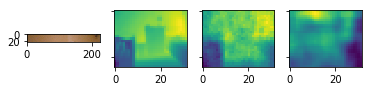

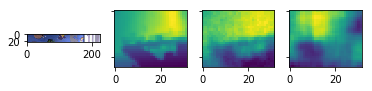

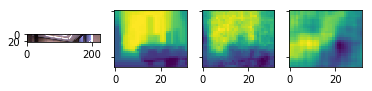

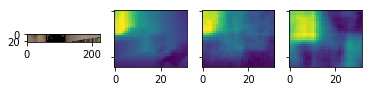

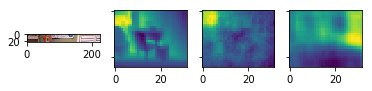

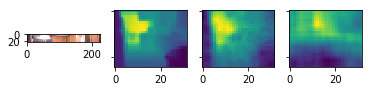

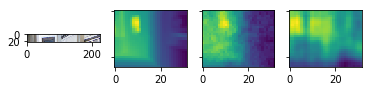

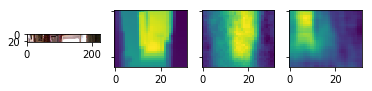

In [43]:
for i in range(batch_size):
    _, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, sharey=True, figsize=(6,6))
    ax0.imshow(img[i].permute(1,2,0).cpu().data.numpy())
    ax1.imshow(d[i].view(depth_size)) # ground truth depth map
    ax2.imshow(d_hat_den[i].view(depth_size).cpu().data.numpy()) # den estimation
    ax3.imshow(d_hat_fdc[i].view(depth_size).cpu().data.numpy()) # den+fdc estimation
    plt.show()